In [1]:
import matplotlib.pyplot as plt
from functools import partial
import jax
import jax.numpy as jnp
from jax import jit, config

#config.update("jax_enable_x64", True)

## モデルとコスト函数

In [2]:
@jit
def florenz(w, p, r, b):
    x, y, z = w
    dwx =      -p * x + p * y 
    dwy = (r - z) * x -     y 
    dwz =           x * y     - b * z
    return jnp.array([dwx, dwy, dwz])

@partial(jit, static_argnums=1)
def fom(w, param):
    p, r, b, dt, nstop = param
    fw = []
    fw.append(w)
    for ntim in range(1, nstop+1):
        w = w + dt * florenz(w, p, r, b)
        fw.append(w)
    return jnp.array(fw)

@partial(jit, static_argnums=(3))
def calc_cost(w, wo, tobs, param):
    wb = fom(w, param)
    return 0.5 * ((wb[tobs] - wo)**2).sum()

@partial(jit, static_argnums=(3,4))
def update(w, wo, tobs, param, alpha=5.0e-4):
    c, g = jax.value_and_grad(calc_cost)(w, wo, tobs, param)
    return w - alpha * g, c

def gen_obs(e, wt, iobs, seed=514):
    key = jax.random.PRNGKey(seed)
    wo = []
    tobs = jnp.array([i for i in range(iobs, wt.shape[0], iobs)])
    for i in range(iobs, wt.shape[0], iobs):
        wo.append(wt[i, :] + e[:] * 2.0 * (jax.random.uniform(key, [e.size,]) - 0.5))
    return jnp.array(wo), tobs

## 順モデルの確認

In [3]:
p = 10.0
r = 32.0
b = 8. / 3.
dt = 0.01

In [4]:
nstop = 500
param = p, r, b, dt, nstop
w0 = jnp.array([1., 3., 5.])
f1 = fom(w0, param)
w1 = w0 * 1.1
f2 = fom(w1, param)

2023-08-15 16:35:12.801509: W pjrt_plugin/src/mps_client.cc:535] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!


Metal device set to: Apple M1 Pro


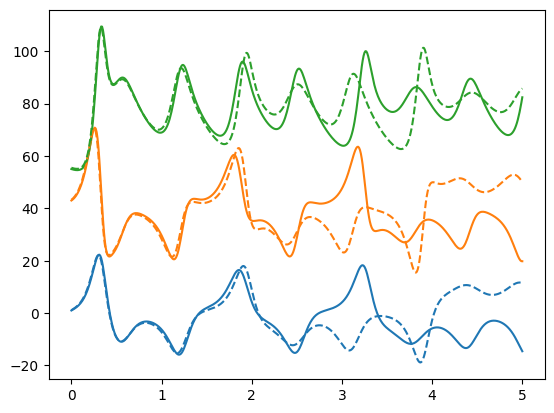

In [5]:
x = jnp.linspace(0, dt*nstop, nstop+1)
off = jnp.array([0, 40, 50])
f1 = f1 + off
fig, ax = plt.subplots()
ax.plot(x, f1)
plt.gca().set_prop_cycle(None)
f2 = f2 + off
ax.plot(x, f2, linestyle="--")
plt.show()

## データ同化の実行

In [6]:
def run_ad(w, wo, tobs, param, alpha=5e-4, itermax=100, cycles=[]):
    hist = []
    cost = []
    for i in range(itermax+1):
        if i in cycles:
            hist.append(fom(w, param))
        w, c = update(w, wo, tobs, param, alpha)
        cost.append(c)
    return cost, hist

In [7]:
nstop = 200
param = p, r, b, dt, nstop
iobs = 60
alpha = 5.0e-4

itermax = 100
cycles=[1, 2, 3, 5, 10, 30]

w0 = jnp.array([1.0, 3.0, 5.0])
e = w0 * 0.1

wt = fom(w0, param)
wo, tobs = gen_obs(e, wt, iobs)
w = w0 * 1.1

cost, hist = run_ad(w, wo, tobs, param, cycles=cycles)

### ベンチマーク

MacBook Pro 2021 Apple M1 Pro 32GB

実行時コンパイルで約57倍高速化したが、手書きより50倍遅い。

- 実行時コンパイルなし: 4min 23s ± 2.79 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
- 実行時コンパイルあり: 4.64 s ± 20.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
- 手書き随伴モデル: 92.5 ms ± 238 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

In [8]:
%timeit run_ad(w, wo, tobs, param)

4.15 s ± 37.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
%timeit run_ad(w, wo, tobs, param)

4.17 s ± 35.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 結果の図示

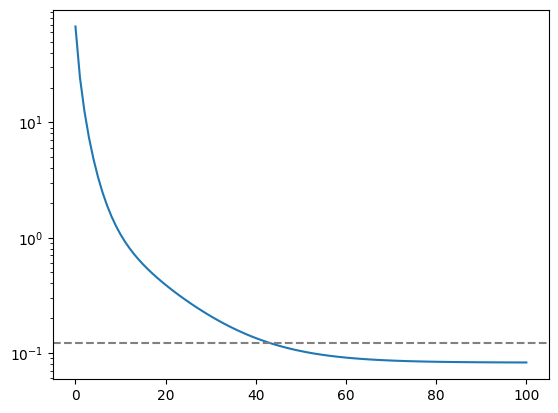

In [10]:
costc = 0.5 * ((wt[tobs] - wo)**2).sum()

fig, ax = plt.subplots()
ax.semilogy(cost)
ax.axhline(costc, c="gray", linestyle="--")
plt.show()

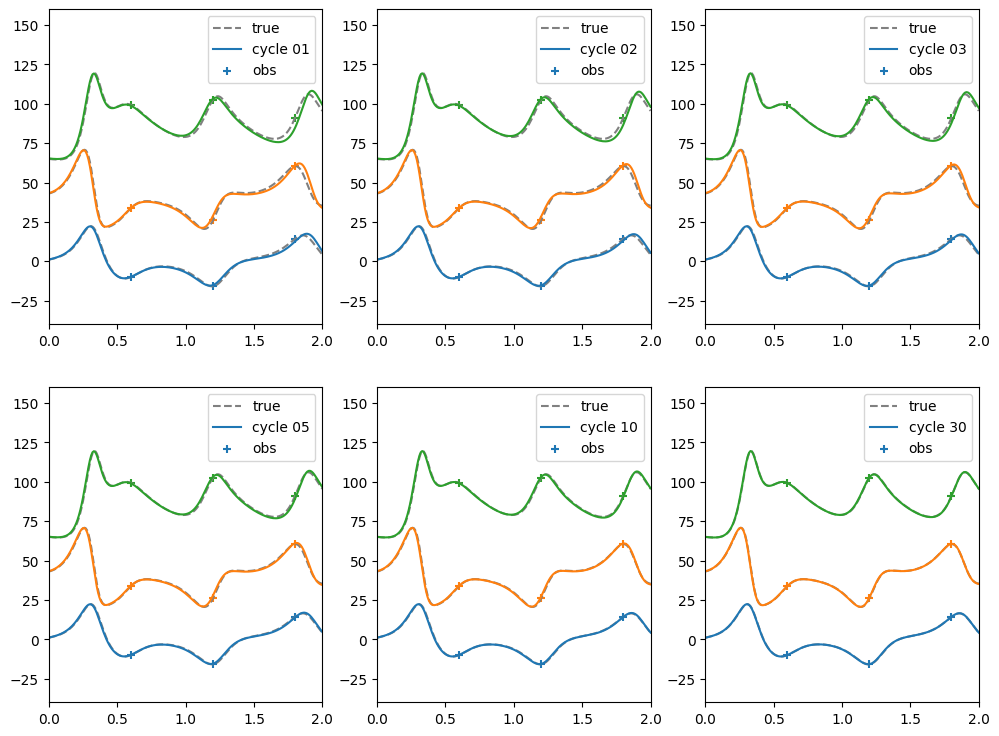

In [11]:
x = jnp.linspace(0, dt * nstop, nstop+1) 
xt = tobs * dt

nx, ny = 2, 3
off = jnp.array([0, 40, 60])
fig, ax = plt.subplots(nx, ny, figsize=[12, 9])
wtrue = wt + off
wobs = wo + off

k = 0
for n in range(len(cycles)):
    ncyc = cycles[n]
    i, j = k // ny, k % ny
    k += 1
    whist = hist[n] + off
    ax[i, j].plot(x, wtrue, c="gray", linestyle="--", label=["true","",""])
    ax[i, j].plot(x, whist, label=[f"cycle {ncyc:02}","",""])
    ax[i, j].set_prop_cycle(None)
    ax[i, j].scatter(xt, wobs[:,0], marker="+", label="obs")
    ax[i, j].scatter(xt, wobs[:,1], marker="+")
    ax[i, j].scatter(xt, wobs[:,2], marker="+")
    ax[i, j].set_xlim([0.0, 2.0])
    ax[i, j].set_ylim([-40, 160])
    ax[i, j].legend(loc="upper right")